Path to notebook: [https://www.github.com/microsoft/presidio/blob/main/docs/samples/python/example_dicom_image_redactor.ipynb](https://www.github.com/microsoft/presidio/blob/main/docs/samples/python/example_dicom_image_redactor.ipynb)

# De-identifying sensitive burnt-in text in DICOM images
This notebook covers how to:
1. Redact text Personal Health Information (PHI) present as pixels in DICOM images
2. Visually compare original DICOM images with their redacted versions

> *This module only redacts pixel data and does not scrub text PHI which may exist in the DICOM metadata. To redact sensitive information from metadata, consider using another package such as the [Tools for Health Data Anonymization](https://github.com/microsoft/Tools-for-Health-Data-Anonymization).*

## Prerequisites
Before getting started, make sure presidio and the latest version of Tesseract OCR are installed. For detailed documentation, see the [installation docs](https://microsoft.github.io/presidio/installation).

In [ ]:
!pip install presidio_analyzer presidio_anonymizer presidio_image_redactor
!python -m spacy download en_core_web_lg

## Dataset
Sample DICOM files are available for use in this notebook in `./sample_data`. Copies of the original DICOM data were saved into the folder with permission from the dataset owners. Please see the original dataset information below:
> Rutherford, M., Mun, S.K., Levine, B., Bennett, W.C., Smith, K., Farmer, P., Jarosz, J., Wagner, U., Farahani, K., Prior, F. (2021). A DICOM dataset for evaluation of medical image de-identification (Pseudo-PHI-DICOM-Data) [Data set]. The Cancer Imaging Archive. DOI: https://doi.org/10.7937/s17z-r072

In [1]:
import glob
from pathlib import Path
import matplotlib.pyplot as plt
import pydicom
from presidio_image_redactor import DicomImageRedactorEngine

## 1. Setup

In [2]:
def compare_dicom_images(
    instance_original: pydicom.dataset.FileDataset,
    instance_redacted: pydicom.dataset.FileDataset,
    figsize: tuple = (11, 11)
) -> None:
    """Display the DICOM pixel arrays of both original and redacted as images.

    Args:
        instance_original (pydicom.dataset.FileDataset): A single DICOM instance (with text PHI).
        instance_redacted (pydicom.dataset.FileDataset): A single DICOM instance (redacted PHI).
        figsize (tuple): Figure size in inches (width, height).
    """
    _, ax = plt.subplots(1, 2, figsize=figsize)
    ax[0].imshow(instance_original.pixel_array, cmap="gray")
    ax[0].set_title('Original')
    ax[1].imshow(instance_redacted.pixel_array, cmap="gray")
    ax[1].set_title('Redacted')

Instantiate the DICOM image redactor engine object.

> *Note: The `DicomImageRedactorEngine` object can initialized with a custom `ImageAnalyzerEngine`, which may be useful in cases where DICOM metadata is insufficient.*

In [3]:
engine = DicomImageRedactorEngine()

## 2. Redacting from loaded DICOM image data

In cases where you already working with loaded DICOM data, the `.redact()` function is most appropriate.

In [4]:
# Load in and process your DICOM file as needed
dicom_instance = pydicom.dcmread('sample_data/0_ORIGINAL.dcm')

In [5]:
# Redact
redacted_dicom_instance = engine.redact(dicom_instance, fill="contrast")

### 2.2 Verify performance
Let's look at the original input and compare against the de-identified output.

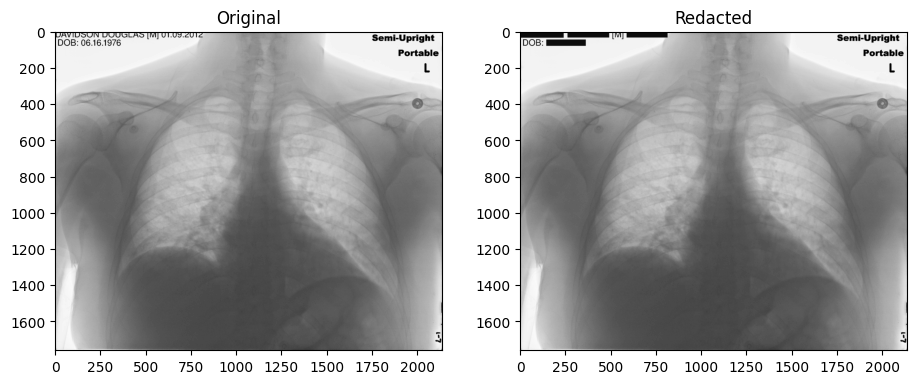

In [6]:
compare_dicom_images(dicom_instance, redacted_dicom_instance)

We can also set the "fill" to match the background color to blend in more with the image.

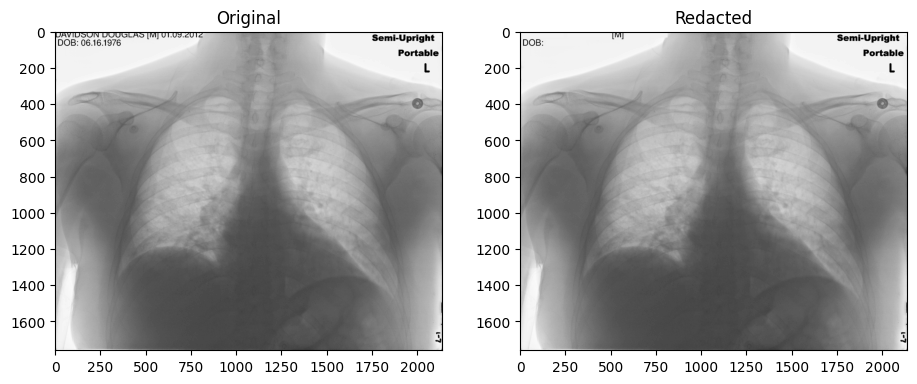

In [7]:
redacted_dicom_instance_2 = engine.redact(dicom_instance, fill="background")
compare_dicom_images(dicom_instance, redacted_dicom_instance_2)

### 2.3 Adjust parameters
With the `use_metadata` parameter, we can toggle whether the DICOM metadata is used to augment the analyzer which determines which text to redact.

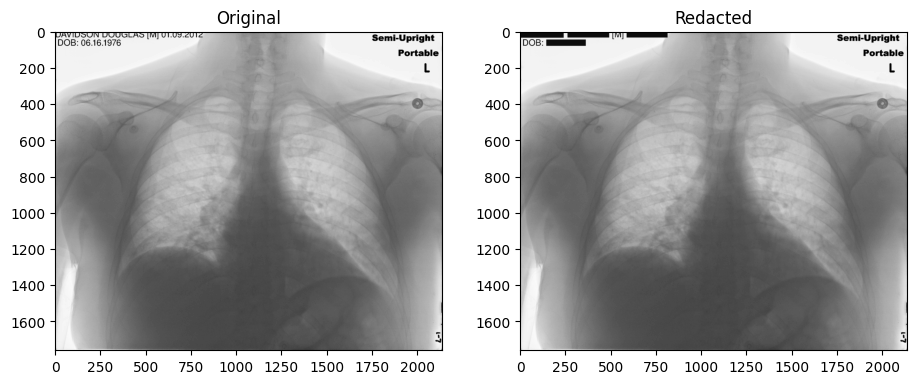

In [8]:
redacted_dicom_instance = engine.redact(dicom_instance, use_metadata=False) # default is use_metadata=True
compare_dicom_images(dicom_instance, redacted_dicom_instance)

We can also return the bounding box information for the pixel regions that were redacted.

Number of redacted regions: 4
[{'top': 0, 'left': 0, 'width': 241, 'height': 37}, {'top': 0, 'left': 262, 'width': 230, 'height': 36}, {'top': 1, 'left': 588, 'width': 226, 'height': 35}, {'top': 47, 'left': 145, 'width': 218, 'height': 35}]


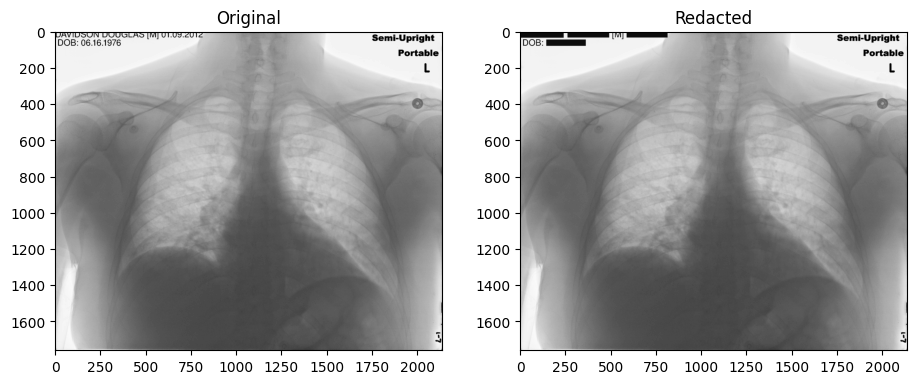

In [9]:
redacted_dicom_instance, bbox = engine.redact_and_return_bbox(dicom_instance)
compare_dicom_images(dicom_instance, redacted_dicom_instance)
print(f"Number of redacted regions: {len(bbox)}")
print(bbox)

## 3. Redacting from DICOM files
Before instantiating your `DicomImageRedactorEngine` class, determine where you want your input to come from and where you want your output to be written to.

> **Note**: The output will mimic the folder structure of the input if the input is a directory. The redact method will operate on all DICOM (.dcm) files in the input directory and all its subdirectories.

To protect against overwriting the original DICOM files, the `redact_from_file()` and `redact_from_directory()` methods will not run if the `output_dir` is a directory which already contains any content.

In [10]:
# Single DICOM (.dcm) file or directory containing DICOM files
input_path = 'sample_data/'

# Directory where the output will be written
output_parent_dir = 'output/'

### 3.1. Run de-identification
Use the `DicomImageRedactorEngine` class to process your DICOM images. If you have only one image to process and want to specify that directly instead of a directory, use `.redact_from_file()` instead of `.redact_from_directory()`.

In [11]:
# Redact text PHI from DICOM images
engine.redact_from_directory(
    input_dicom_path = input_path,
    output_dir = output_parent_dir,
    fill="contrast",
    save_bboxes=True # if True, saves the redacted region bounding box info to .json files in the output dir
)

Output written to output\sample_data


### 3.2. Verify performance
Let's look at the original input and compare against the de-identified output.

Get file paths

In [12]:
# Original DICOM images
p = Path(input_path).glob("**/*.dcm")
original_files = [x for x in p if x.is_file()]

# Redacted DICOM images
p = Path(output_parent_dir).glob("**/*.dcm")
redacted_files = [x for x in p if x.is_file()]

Preview images

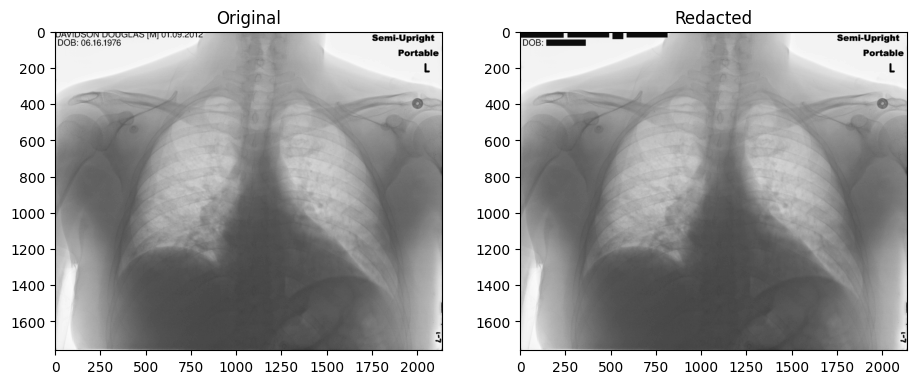

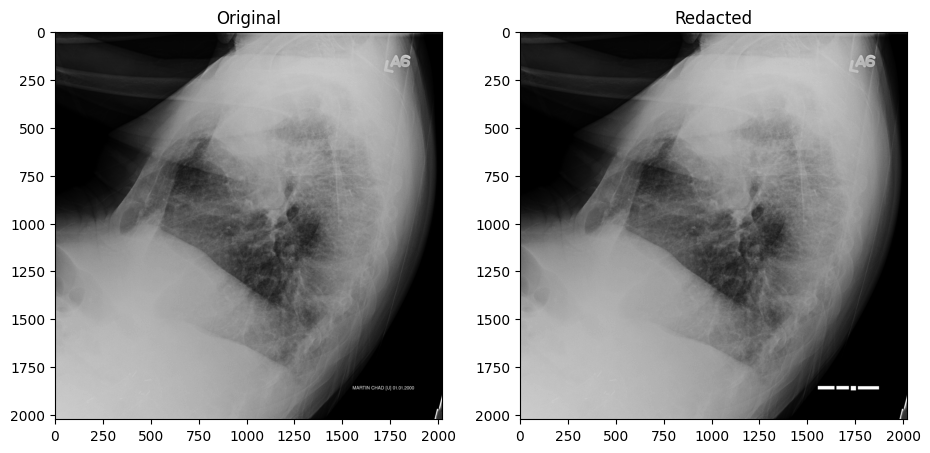

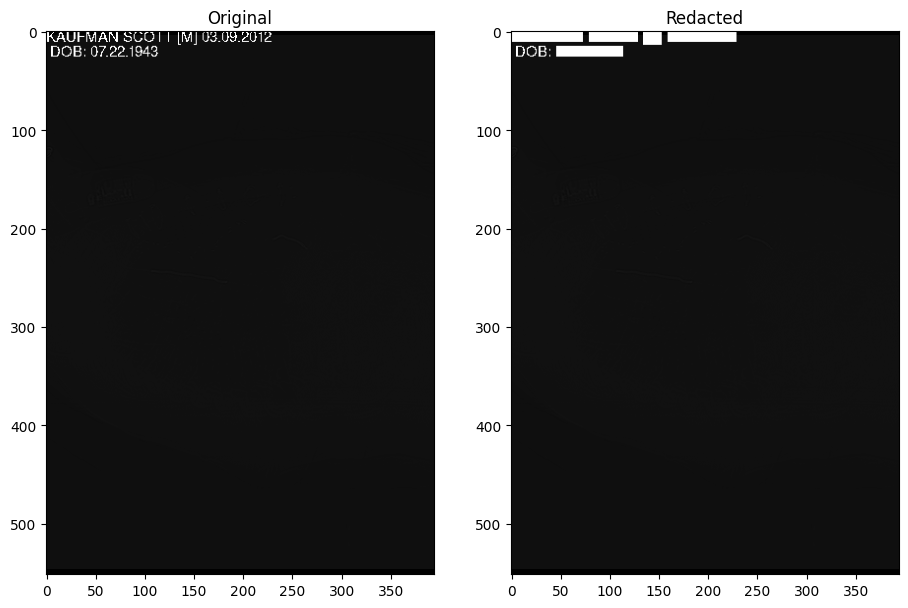

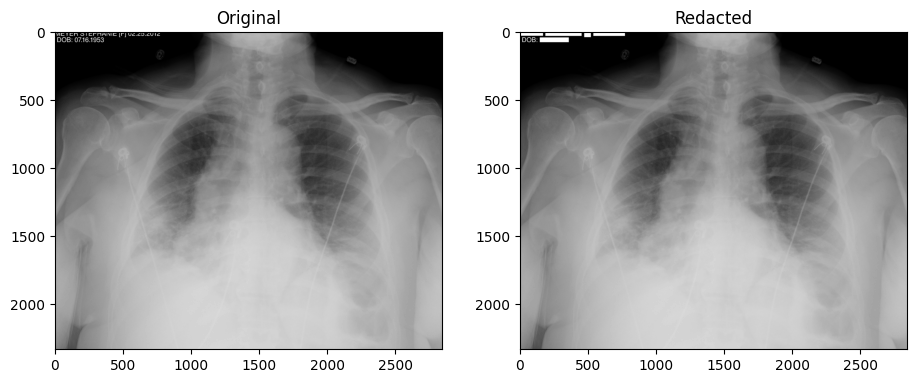

In [13]:
for i in range(0, len(original_files)):
    original_file = pydicom.dcmread(original_files[i])
    redacted_file = pydicom.dcmread(redacted_files[i])
    
    compare_dicom_images(original_file, redacted_file)

## Conclusion
As seen in the DICOM image previews above, we see that our `DicomImageRedactorEngine` is able to successfully mask out text PHI present in the DICOM images without compromising image quality.

**Note**: Performance is best when the burnt-in text is also present within the DICOM metadata. We recommend not scrubbing metadata until after performing image de-identification.